<a href="https://colab.research.google.com/github/GrigoryBartosh/dul_2021/blob/main/Homework/hw7/Homework7_gans.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!if [ -d dul_2021 ]; then rm -Rf dul_2021; fi
!git clone https://github.com/GrigoryBartosh/dul_2021
!pip install ./dul_2021

In [2]:
from dul_2021.utils.hw7_utils import *

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np

from torch.utils.data import DataLoader
from scipy.stats import norm
from tqdm import trange, tqdm

# Question 1: GANs on CIFAR-10

In this exercise, you will train GANs on CIFAR-10. Execute the cell below to visualize the dataset. 

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data


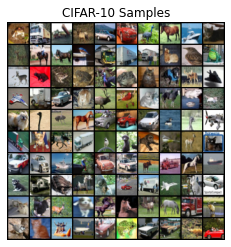

In [6]:
visualize_q1_data()

 We'll use the CIFAR-10 architecture from the [SN-GAN paper](https://arxiv.org/pdf/1802.05957.pdf), with $z \in \mathbb R ^{128}$, with $z \sim \mathcal N (0, I_{128})$. Instead of upsampling via transposed convolutions and downsampling via pooling or striding, we'll use these DepthToSpace and SpaceToDepth methods for changing the spatial configuration of our hidden states. 

```
class DepthToSpace(nn.Module):
    def __init__(self, block_size):
        super().__init__()
        self.block_size = block_size
        self.block_size_sq = block_size * block_size

    def forward(self, input):
        output = input.permute(0, 2, 3, 1)
        (batch_size, d_height, d_width, d_depth) = output.size()
        s_depth = int(d_depth / self.block_size_sq)
        s_width = int(d_width * self.block_size)
        s_height = int(d_height * self.block_size)
        t_1 = output.reshape(batch_size, d_height, d_width, self.block_size_sq, s_depth)
        spl = t_1.split(self.block_size, 3)
        stack = [t_t.reshape(batch_size, d_height, s_width, s_depth) for t_t in spl]
        output = torch.stack(stack, 0).transpose(0, 1).permute(0, 2, 1, 3, 4).reshape(batch_size, s_height, s_width,
                                                                                      s_depth)
        output = output.permute(0, 3, 1, 2)
        return output


class SpaceToDepth(nn.Module):
    def __init__(self, block_size):
        super().__init__()
        self.block_size = block_size
        self.block_size_sq = block_size * block_size

    def forward(self, input):
        output = input.permute(0, 2, 3, 1)
        (batch_size, s_height, s_width, s_depth) = output.size()
        d_depth = s_depth * self.block_size_sq
        d_width = int(s_width / self.block_size)
        d_height = int(s_height / self.block_size)
        t_1 = output.split(self.block_size, 2)
        stack = [t_t.reshape(batch_size, d_height, d_depth) for t_t in t_1]
        output = torch.stack(stack, 1)
        output = output.permute(0, 2, 1, 3)
        output = output.permute(0, 3, 1, 2)
        return output

# Spatial Upsampling with Nearest Neighbors
Upsample_Conv2d(in_dim, out_dim, kernel_size=(3, 3), stride=1, padding=1):
    x = torch.cat([x, x, x, x], dim=1)
    DepthToSpace(block_size=2)
    Conv2d(in_dim, out_dim, kernel_size, stride=stride, padding=padding)


# Spatial Downsampling with Spatial Mean Pooling
Downsample_Conv2d(in_dim, out_dim, kernel_size=(3, 3), stride=1, padding=1):
        SpaceToDepth(2)
        torch.sum(x.chunk(4, dim=1)) / 4.0
        nn.Conv2d(in_dim, out_dim, kernel_size,
                              stride=stride, padding=padding, bias=bias)
```

Here's pseudocode for how we'll implement a ResBlockUp, used in the generator:

```
ResnetBlockUp(x, in_dim, kernel_size=(3, 3), n_filters=256):
    _x = x
    _x = nn.BatchNorm2d(in_dim)(_x)
    _x = nn.ReLU()(_x)
    _x = nn.Conv2d(in_dim, n_filters, kernel_size, padding=1)(_x)
    _x = nn.BatchNorm2d(n_filters)(_x)
    _x = nn.ReLU()(_x)
    residual = Upsample_Conv2d(n_filters, n_filters, kernel_size, padding=1)(_x)
    shortcut = Upsample_Conv2d(in_dim, n_filters, kernel_size=(1, 1), padding=0)(x)
    return residual + shortcut
```
The ResBlockDown module is similar, except it uses Downsample_Conv2d and omits the BatchNorm.

Finally, here's the architecture for the generator:
```
def Generator(*, n_samples=1024, n_filters=128):
    z = Normal(0, 1)([n_samples, 128])
    nn.Linear(128, 4*4*256)
    reshape output of linear layer
    ResnetBlockUp(in_dim=256, n_filters=n_filters),
    ResnetBlockUp(in_dim=n_filters, n_filters=n_filters),
    ResnetBlockUp(in_dim=n_filters, n_filters=n_filters),
    nn.BatchNorm2d(n_filters),
    nn.ReLU(),
    nn.Conv2d(n_filters, 3, kernel_size=(3, 3), padding=1),
    nn.Tanh()
```
Again, the discriminator has the same architecture, except with ResnetBlockDown and no BatchNorm.

**Hyperparameters**

We'll implement [WGAN-GP](https://arxiv.org/abs/1704.00028), which uses a gradient penalty to regularize the discriminator. Use the Adam optimizer with $\alpha = 2e-4$, $\beta_1 = 0$, $\beta_2 = 0.9$, $\lambda = 10$, $n_{critic} = 5$. Use a batch size of 256 and n_filters=128 within the ResBlocks. Train for at least 25000 gradient steps, with the learning rate linearly annealed to 0 over training. 

**You will provide the following deliverables**
1. Inception score (CIFAR-10 version) of the final model. We provide a utility that will automatically do this for you.
2. Discriminator loss across training
3. 100 samples. 

In [5]:
class Dataset:
  def __init__(self, data):
    self.data = data
  
  def get_data_loader(self, batch_size: int):
    return DataLoader(self.data, batch_size=batch_size, pin_memory=True, 
                      shuffle=True, num_workers=1)

In [ ]:
class DepthToSpace(nn.Module):
  def __init__(self, block_size):
    super(DepthToSpace, self).__init__()
    self.block_size = block_size
    self.block_size_sq = block_size ** 2

  def forward(self, input):
    batch_size, d_depth, d_height, d_width = input.shape
    space_depth = int(d_depth / self.block_size_sq)
    space_width = int(d_width * self.block_size)
    space_height = int(d_height * self.block_size)

    output = input.permute(0, 2, 3, 1).reshape(batch_size, d_height, 
                                               d_width, self.block_size_sq,
                                               space_depth)
    split = output.split(self.block_size, 3)
    stack = [out.reshape(batch_size, d_height, space_width, space_depth) for out in split]
    output = torch.stack(stack, 0).transpose(0, 1).permute(0, 2, 1, 3, 4)
    output = output.reshape(batch_size, space_width, space_height,
                            space_depth).permute(0, 3, 1, 2)
    return output.contiguous()

In [ ]:
class UpsampleConv(nn.Module):
  def __init__(self, in_dim, out_dim, kernel_size=(3, 3), stride=1, 
               padding=1, bias=True):
    super(UpsampleConv, self).__init__()
    self.conv = nn.Conv2d(in_dim, out_dim, kernel_size=kernel_size,
                          padding=padding, bias=bias)
    self.depth_to_space = DepthToSpace(2)

  def forward(self, x):
    x_hat = self.depth_to_space(torch.cat([x, x, x, x], dim=1))
    out = self.conv(x_hat)
    return out

In [ ]:
class ResUpBlock(nn.Module):
  def __init__(self, in_dim, out_dim, kernel_size=(3, 3)):
    super(ResUpBlock, self).__init__()
    block = [nn.BatchNorm2d(in_dim),
             nn.ReLU(),
             nn.Conv2d(in_dim, out_dim, kernel_size=kernel_size, padding=1),
             nn.BatchNorm2d(out_dim),
             nn.ReLU(),
             UpsampleConv(out_dim, out_dim)]
    self.block = nn.Sequential(*block)
    self.upsample = UpsampleConv(in_dim, out_dim, kernel_size=(1, 1), padding=0)

  def forward(self, x):
    x_hat = x
    for layer in self.block:
      x_hat = layer(x_hat)
    return self.upsample(x) + x_hat

In [ ]:
class Generator(nn.Module):
  def __init__(self):
    super(Generator, self).__init__()
    self.linear = nn.Linear(128, 4 * 4 * 256)
    model = [ResUpBlock(256, 256),
             ResUpBlock(256, 256),
             ResUpBlock(256, 256),
             nn.BatchNorm2d(256),
             nn.ReLU(),
             nn.Conv2d(256, 3, kernel_size=(3, 3), padding=1),
             nn.Tanh()]
    self.model = nn.Sequential(*model)

    self.noise = torch.distributions.Normal(torch.tensor(0.), torch.tensor(1.))

  def forward(self, z):
    z = self.linear(z).reshape(-1, 256, 4, 4)
    return self.model(z)
  
  def sample(self, n_samples=100):
    z = self.noise.sample([n_samples, 128]).to(device)
    return self(z)

In [ ]:
class SpaceToDepth(nn.Module):
    def __init__(self, block_size):
        super(SpaceToDepth, self).__init__()
        self.block_size = block_size
        self.block_size_sq = block_size ** 2

    def forward(self, input):
        batch_size, s_depth, s_width, s_height = input.shape
        d_depth = s_depth * self.block_size_sq
        d_width = int(s_width / self.block_size)
        d_height = int(s_height / self.block_size)
        
        output = input.permute(0, 2, 3, 1).split(self.block_size, 2)
        stack = torch.stack(
            [out.reshape(batch_size, d_height, d_depth) for out in output], 1)

        output = stack.permute(0, 3, 2, 1)
        return output.contiguous()

In [ ]:
class DownsampleConv(nn.Module):
    def __init__(self, in_dim, out_dim, kernel_size=(3, 3), stride=1, padding=1, bias=True):
        super(DownsampleConv, self).__init__()
        self.conv = nn.Conv2d(in_dim, out_dim, kernel_size,
                              stride=stride, padding=padding, bias=bias)
        self.space_to_depth = SpaceToDepth(2)

    def forward(self, x):
        x_hat = sum(self.space_to_depth(x).chunk(4, dim=1)) / 4.0
        return self.conv(x_hat)

In [ ]:
class ResDownBlock(nn.Module):
    def __init__(self, in_dim, out_dim, kernel_size=(3, 3), stride=1):
        super(ResDownBlock, self).__init__()
        block = [nn.ReLU(),
                 nn.Conv2d(in_dim, out_dim, kernel_size=kernel_size, 
                           stride=stride, padding=1),
                 nn.ReLU(),
                 DownsampleConv(out_dim, out_dim, kernel_size)]
        self.block = nn.Sequential(*block)      
        self.downsample = DownsampleConv(in_dim, out_dim, kernel_size=(1, 1), padding=0)

    def forward(self, x):
        x_hat = x
        for layer in self.block:
            x_hat = layer(x_hat)
        return self.downsample(x) + x_hat

In [ ]:
class ResBlock(nn.Module):
    def __init__(self, in_dim, out_dim, kernel_size=(3, 3)):
        super(ResBlock, self).__init__()
        layers = [nn.ReLU(),
                  nn.Conv2d(in_dim, out_dim, kernel_size=kernel_size, padding=1),
                  nn.ReLU(),
                  nn.Conv2d(out_dim, out_dim, kernel_size=kernel_size, padding=1)]
        self.layers = nn.Sequential(*layers)

    def forward(self, x):
        x_hat = x
        for layer in self.layers:
            x_hat = layer(x_hat)
        return x + x_hat

In [ ]:
class GradientPenalty():
  def __init__(self, discriminator):
    self.discriminator = discriminator

  def __call__(self, real_data, fake_data, gamma: float = 1e-12):
    bs = real_data.shape[0]
    eps = torch.rand(bs, 1, 1, 1).to(device)
    eps = eps.expand(real_data.size())
    interpolated = eps * real_data.data + (1 - eps) * fake_data.data
    interpolated.requires_grad = True

    output = self.discriminator(interpolated)
    gradients = torch.autograd.grad(outputs=output, inputs=interpolated,
                                    grad_outputs=torch.ones(output.size()).to(device),
                                    create_graph=True, retain_graph=True)[0].reshape(bs, -1)
    gradients = torch.sqrt(torch.sum(gradients ** 2, dim=1) + gamma)
    return ((gradients - 1) ** 2).mean()

In [ ]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        model = [ResDownBlock(3, 128),
                 ResDownBlock(128, 128),
                 ResDownBlock(128, 256),
                 nn.ReLU(),
                 nn.Conv2d(256, 128, kernel_size=(3, 3), padding=1)]
        self.model = nn.Sequential(*model)
        self.linear = nn.Linear(128 * 4 * 4, 1)

    def forward(self, z):
        z = self.model(z).reshape(-1, 128 * 4 * 4)
        return self.linear(z)

In [ ]:
class SNGAN(nn.Module):
  def __init__(self, dataloader, n_iterations=1_000):
    super(SNGAN, self).__init__()

    self.update_disc_each_n = 5
    self.batch_size = 256
    self.out_dim = 128
    self.iter = 0

    self.train_loader = dataloader
    self.n_epochs = self.update_disc_each_n * n_iterations // len(self.train_loader)

    self.generator = Generator().to(device)
    self.discriminator = Discriminator().to(device)

    self.g_optimizer = torch.optim.Adam(self.generator.parameters(), 
                                        lr=2e-4, betas=(0, 0.9))
    self.g_scheduler = torch.optim.lr_scheduler.LinearLR(self.g_optimizer,
                                                       start_factor=1, end_factor=0,
                                                       total_iters=n_iterations)
    
    self.d_optimizer = torch.optim.Adam(self.discriminator.parameters(), lr=2e-4, betas=(0, 0.9))
    self.d_scheduler = torch.optim.lr_scheduler.LinearLR(self.d_optimizer,
                                                       start_factor=1, end_factor=0,
                                                       total_iters=n_iterations)
    
    self.gradient_penalty = GradientPenalty(self.discriminator)


  def train(self):
        train_losses = []

        for epoch in trange(self.n_epochs, desc='epoch'):
            epoch += 1
            self.discriminator.train()
            self.generator.train()
            self.batch_loss = []

            for batch, x in enumerate(tqdm(self.train_loader, desc='batch', disable=True)):
                batch += 1
                self.iter += 1
                x = ((x.float() - 0.5) * 2).to(device)

                self.d_optimizer.zero_grad()
                fake_data = self.generator.sample(x.shape[0])
                penalty = self.gradient_penalty(x, fake_data)
                disc_loss = self.discriminator(fake_data).mean() - self.discriminator(x).mean() + 10 * penalty
                disc_loss.backward()
                self.d_optimizer.step()

                if self.iter % self.update_disc_each_n == 0:
                    self.g_optimizer.zero_grad()
                    fake_data = self.generator.sample(self.batch_size)
                    gen_loss = -self.discriminator(fake_data).mean()
                    gen_loss.backward()
                    self.g_optimizer.step()
                    self.g_scheduler.step()
                    self.d_scheduler.step()
                    self.batch_loss.append(gen_loss.data.cpu().numpy())

            epoch_loss = np.mean(self.batch_loss)
            train_losses.append(epoch_loss)

        train_losses = np.array(train_losses)
        return train_losses

## Solution

In [ ]:
def q1(train_data):
    """
    train_data: An (n_train, 3, 32, 32) numpy array of CIFAR-10 images with values in [0, 1]

    Returns
    - a (# of training iterations,) numpy array of WGAN critic train losses evaluated every minibatch
    - a (1000, 32, 32, 3) numpy array of samples from your model in [0, 1]. 
        The first 100 will be displayed, and the rest will be used to calculate the Inception score. 
    """

    """ YOUR CODE HERE """
    train_dataset = Dataset(train_data)
    train_dataloader = train_dataset.get_data_loader(batch_size=256)
    gan = SNGAN(train_dataloader)
    losses = gan.train()

    gan.generator.eval()
    gan.discriminator.eval()
    with torch.no_grad():
        samples = gan.generator.sample(1000)
        samples = samples.permute(0, 2, 3, 1).detach().cpu().numpy() * 0.5 + 0.5

    return losses, samples

## Results

Files already downloaded and verified


epoch: 100%|██████████| 25/25 [3:38:09<00:00, 523.59s/it]


..........Inception score: 4.4231424


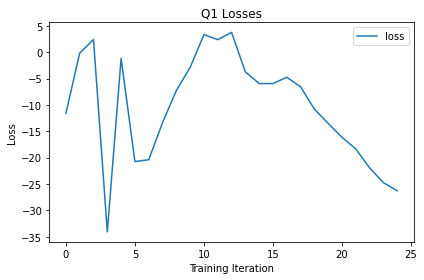

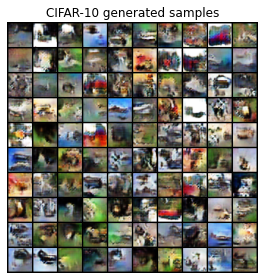

In [ ]:
q1_save_results(q1)

# Question 2: Representation Learning with BiGAN on MNIST

In this part, we train a BiGAN on the MNIST dataset. Execute the cell below to visualize the dataset.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


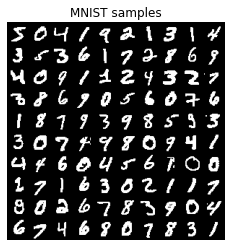

In [ ]:
visualize_q2_data()

In BiGAN, in addition to training a generator $G$ and a discriminator $D$, we train an encoder $E$ that maps from real images $x$ to latent codes $z$. The discriminator now must learn to jointly identify fake $z$, fake $x$, and paired $(x, z)$ that don't belong together. In the original [BiGAN paper](https://arxiv.org/pdf/1605.09782.pdf), they prove that the optimal $E$ learns to invert the generative mapping $G: z \rightarrow x$. Our overall minimax term is now
$$V(D, E, G) = \mathbb{E}_{x \sim p_x}[\mathbb{E}_{z \sim p_E(\cdot | x)}[\log D(x, z)]] + \mathbb{E}_{z \sim p_z}[\mathbb{E}_{x \sim p_G(\cdot | z)}[\log (1 - D(x, z))]]$$

**Architecture**

We will closely follow the MNIST architecture outlined in the original BiGAN paper, Appendix C.1, with one modification: instead of having $z \sim \text{Uniform}[-1, 1]$, we use $z \sim \mathcal N (0, 1)$ with $z \in \mathbb R ^{50}$. 

**Hyperparameters**

We make several modifications to what is listed in the BiGAN paper. We apply $l_2$ weight decay to all weights and decay the step size $\alpha$ linearly to 0 over the course of training. Weights are initialized via the default PyTorch manner. We recommend training for at least 100 epochs -- this part is much less computationally expensive than previous homeworks. 

**Reconstructions**

You should take the first 20 images from the MNIST training set and then display the reconstructions $x_{recon} = G(E(x))$. It's ok if your reconstructions are somewhat lossy; ours are too. We will provide a utility to show these. 

**Testing the representation**

We want to see how good a linear classifier $L$ we can learn such that 
$$y \approx L(E(x))$$
where $y$ is the appropriate label. Fix $E$ and learn a weight matrix $W$ such that your linear classifier is composed of passing $x$ through $E$, then multiplying by $W$, then applying a softmax nonlinearity. Train this via gradient descent with the cross-entropy loss. 

As a baseline, randomly initialize another network $E_{random}$ with the same architecture, fix its weights, and train a linear classifier on top, as done in the previous part.


**You will provide the following deliverables**
1. Plot of the minimax loss term. 
2. 100 samples from the BiGAN
3. A comparison of MNIST images $x$ with their reconstructions $G(E(x))$.
4. Test loss plot for the linear classifier trained on the pretrained encoder, and a randomly initialized encoder. 
5. Final test losses for the two linear classifiers. 

**Feel free to train the networks separately, save the necessary information, and simply use our function to generate the appropriate figures.**


In [6]:
class Encoder(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(Encoder, self).__init__()

        self.model = nn.Sequential(
            nn.Linear(input_dim, 1024),
            nn.LeakyReLU(0.2),
            nn.Linear(1024, 1024),
            nn.BatchNorm1d(1024, affine=False),
            nn.LeakyReLU(0.2),
            nn.Linear(1024, output_dim),
        )

    def forward(self, x):
        batch_size = x.shape[0]
        output = self.model(x.reshape(batch_size, -1))
        return output

In [7]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()

        self.model = nn.Sequential(
            nn.Linear(50, 1024),
            nn.ReLU(),
            nn.Linear(1024, 1024),
            nn.BatchNorm1d(1024, affine=False),
            nn.ReLU(),
            nn.Linear(1024, 28 * 28),
            nn.Tanh()
        )

        self.distribution = torch.distributions.Normal(
            torch.tensor(0, dtype=torch.float32).to(device),
            torch.tensor(1, dtype=torch.float32).to(device))

    def forward(self, z):
        batch_size = z.shape[0]
        output = self.model(z).reshape(batch_size, 1, 28, 28)
        return output

    def sample(self, n_samples):
        z = self.distribution.sample((n_samples, 50))
        return self(z), z


In [8]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()

        self.model = nn.Sequential(
            nn.Linear(834, 1024),
            nn.LeakyReLU(0.2),
            nn.Linear(1024, 1024),
            nn.BatchNorm1d(1024, affine=False),
            nn.LeakyReLU(0.2),
            nn.Linear(1024, 1),
            nn.Sigmoid()
        )

    def forward(self, z, x):
        batch_size = x.shape[0]
        flatten_x = x.reshape(batch_size, -1)
        output = self.model(torch.cat([z, x.reshape(batch_size, -1)], dim=1))    
        return output

In [31]:
class BiGAN(nn.Module):
    def __init__(self):
        super(BiGAN, self).__init__()

        self.generator = Generator().to(device)
        self.discriminator = Discriminator().to(device)
        self.encoder = Encoder(28 * 28, 50).to(device)
        self.classifier = nn.Linear(50, 10).to(device)

        self.epochs = 20
        self.batch_size = 256

    def loss(self, real_data):
      batch_size = real_data.shape[0]

      z_real = self.encoder(real_data)
      real_loss = self.discriminator(z_real, real_data)

      fake_data, z_fake = self.generator.sample(batch_size)
      fake_loss = self.discriminator(z_fake, fake_data)

      loss = torch.log(real_loss) + torch.log(1 - fake_loss)

      return -loss.mean()


    def evaluate(self, dataloader):
      total_loss = []
      for batch, label in dataloader:
        batch = batch.to(device)
        label = label.to(device)

        z = self.encoder(batch)

        loss = F.cross_entropy(self.classifier(z), label)
        total_loss.append(loss.item())
      return np.mean(total_loss)

    def fit_classifier(self, train_loader, eval_loader):
        classifier_optimizer = torch.optim.Adam(self.classifier.parameters(), lr=1e-3)

        train_losses = []
        val_losses = []

        self.encoder.eval()
        val_losses.append(self.evaluate(eval_loader))

        for epoch in trange(self.epochs, desc="Training classifier"):
          for batch, label in train_loader:
            batch = batch.to(device)
            label = label.to(device)

            with torch.no_grad():
              z = self.encoder(batch)

            loss = F.cross_entropy(self.classifier(z), label)

            classifier_optimizer.zero_grad()
            loss.backward()
            classifier_optimizer.step()

            train_losses.append(loss.item())
          val_losses.append(self.evaluate(eval_loader))

        self.encoder.train()

        return train_losses, val_losses 

    def fit(self, train_loader, val_loader):
        generator_params = list(self.encoder.parameters()) + list(self.generator.parameters())
        generator_optimizer = torch.optim.Adam(generator_params, lr=2e-4, betas=(0.5, 0.9))
        generator_scheduler = torch.optim.lr_scheduler.LambdaLR(generator_optimizer,
                                                                lambda epoch: (self.epochs - epoch) / self.epochs,
                                                                last_epoch=-1)
        discriminator_optimizer = torch.optim.Adam(self.discriminator.parameters(), lr=2e-4, betas=(0, 0.9)) 
        discriminator_scheduler = torch.optim.lr_scheduler.LambdaLR(discriminator_optimizer,
                                                            lambda epoch: (self.epochs - epoch) / self.epochs,
                                                            last_epoch=-1)
        eval_losses = []
        train_losses = []

        eval_losses.append(self.evaluate(val_loader))
        for epoch in trange(self.epochs, desc="Train Bi Gan"):
            for batch, label in val_loader:
                batch = batch.to(device)
                disc_loss = self.loss(batch)
                discriminator_optimizer.zero_grad()
                disc_loss.backward()
                discriminator_optimizer.step()

                gen_loss = -self.loss(batch)
                generator_optimizer.zero_grad()
                gen_loss.backward()
                generator_optimizer.step()

            train_losses.append(self.evaluate(val_loader))
            generator_scheduler.step()
            discriminator_scheduler.step()
        return np.array(train_losses), np.array(eval_losses)


    def sample(self, n):
      noise = torch.rand(n, 50).to(device) - 0.5
      z = 2 * noise 

      self.generator.eval()
      samples = 0.5 * self.generator(z) + 0.5
      self.generator.train()
      return samples.cpu().detach().numpy().transpose(0, 2, 3, 1)

    
    def reconstruct(self, batch):
      batch = batch.to(device)
      self.encoder.eval()
      self.generator.eval()
      z = self.encoder(batch)
      z_hat = self.generator(z)
      self.encoder.train()
      self.generator.train()

      data = 0.5 * torch.cat([batch, z_hat]) + 0.5

      return data.detach().cpu().numpy().transpose(0, 2, 3, 1)


## Solution

In [32]:
def q2(train_data, test_data):
    """
    train_data: A PyTorch dataset that contains (n_train, 28, 28) MNIST digits, normalized to [-1, 1]
                Documentation can be found at torchvision.datasets.MNIST
    test_data: A PyTorch dataset that contains (n_test, 28, 28) MNIST digits, normalized to [-1, 1]
                Documentation can be found at torchvision.datasets.MNIST

    Returns
    - a (# of training iterations,) numpy array of BiGAN minimax losses evaluated every minibatch
    - a (100, 28, 28, 1) numpy array of BiGAN samples that lie in [0, 1]
    - a (40, 28, 28, 1) numpy array of 20 real image / reconstruction pairs
    - a (# of training epochs,) numpy array of supervised cross-entropy losses on the BiGAN encoder evaluated every epoch 
    - a (# of training epochs,) numpy array of supervised cross-entropy losses on a random encoder evaluated every epoch 
    """

    """ YOUR CODE HERE """
    train_dataset = Dataset(train_data)
    train_loader = train_dataset.get_data_loader(256)

    test_dataset = Dataset(test_data)
    test_loader = test_dataset.get_data_loader(256)

    bi_gan = BiGAN()

    bi_gan_train_losses,  bi_gan_test_losses = bi_gan.fit_classifier(train_loader, test_loader)
    train_losses, test_losses = bi_gan.fit(train_loader, test_loader)

    samples = bi_gan.sample(100)
    reconstruction_idx = np.random.choice(len(test_data), 20, replace=False)
    reconstruction_batch = torch.stack([test_data[i][0] for i in reconstruction_idx])
    reconstructions = bi_gan.reconstruct(reconstruction_batch)

    bi_gan.classifier.reset_parameters()

    classifier_train_losses, classifier_test_losses = bi_gan.fit_classifier(train_loader, test_loader)

    return train_losses, samples, reconstructions, classifier_test_losses, bi_gan_test_losses


## Results

Training classifier: 100%|██████████| 20/20 [05:22<00:00, 16.11s/it]


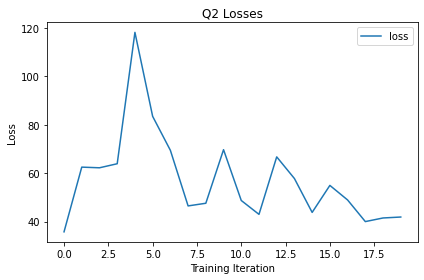

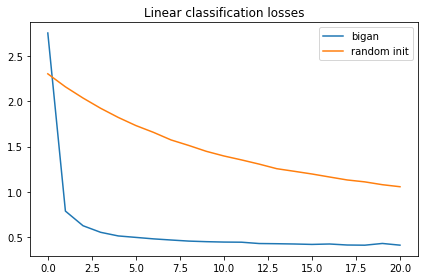

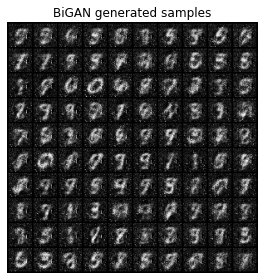

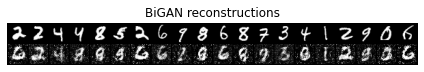

BiGAN final linear classification loss: 0.41273249089717867
Random encoder linear classification loss: 1.0573199838399887


In [33]:
q2_save_results(q2)

# Bonus 5: CycleGAN
In this question, you'll train a CycleGAN model to learn to translate between two different image domains, without any paired data. Execute the following cell to visualize our two datasets: MNIST and Colored MNIST. 

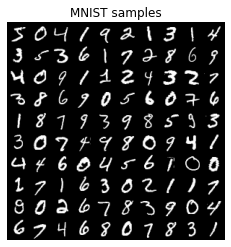

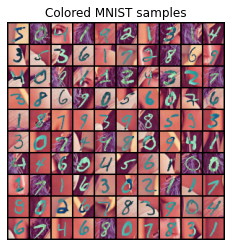

In [ ]:
visualize_cyclegan_datasets()

In [CycleGAN](https://arxiv.org/pdf/1703.10593.pdf), the goal is to learn functions $F$ and $G$ that can transform images from $X \rightarrow Y$ and vice-versa. This is an unconstrained problem, so we additionally enforce the *cycle-consistency* property, where we want 
$$x \approx G(F(x))$$
and  
$$y \approx F(G(x))$$
This loss function encourages $F$ and $G$ to approximately invert each other. In addition to this cycle-consistency loss, we also have a standard GAN loss such that $F(x)$ and $G(y)$ look like real images from the other domain. 

Since this is a bonus question, we won't do much hand-holding. We recommend reading through the original paper to get a sense of what architectures and hyperparameters are useful. Note that our datasets are fairly simple, so you won't need excessively large models. 

**You will report the following deliverables**
1. A set of images showing real MNIST digits, transformations of those images into Colored MNIST digits, and reconstructions back into the greyscale domain. 
2. A set of images showing real Colored MNIST digits, transformations of those images, and reconstructions. 

## Solution

In [ ]:
def b5(mnist_data, cmnist_data):
    """
    mnist_data: An (60000, 1, 28, 28) numpy array of black and white images with values in [0, 1]
    cmnist_data: An (60000, 3, 28, 28) numpy array of colored images with values in [0, 1]

    Returns
    - a (20, 28, 28, 1) numpy array of real MNIST digits, in [0, 1]
    - a (20, 28, 28, 3) numpy array of translated Colored MNIST digits, in [0, 1]
    - a (20, 28, 28, 1) numpy array of reconstructed MNIST digits, in [0, 1]

    - a (20, 28, 28, 3) numpy array of real Colored MNIST digits, in [0, 1]
    - a (20, 28, 28, 1) numpy array of translated MNIST digits, in [0, 1]
    - a (20, 28, 28, 3) numpy array of reconstructed Colored MNIST digits, in [0, 1]
    """
    """ YOUR CODE HERE """

## Results

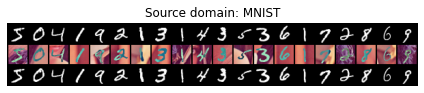

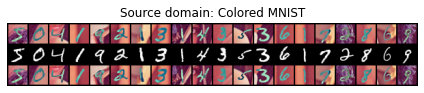

In [ ]:
b5_save_results(b5)